In [1]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
from imutils import paths

In [2]:
# Constants for LBP
RADIUS = 5
N_POINTS = 8 * RADIUS
METHOD = 'uniform'

In [3]:
# Function to extract LBP features from an image block
def calcul_lbp_block(image, P, R):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    lbp = local_binary_pattern(gray, P, R, method=METHOD)
    lbp_histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    lbp_histogram = lbp_histogram.astype('float')
    lbp_histogram /= (lbp_histogram.sum() + 1e-6)  # Normalize histogram
    return lbp_histogram

In [4]:
# Divide an image into a grid of regions
def divide_image(image, num_rows, num_cols):
    height, width = image.shape
    region_height = height // num_rows
    region_width = width // num_cols
    regions = []
    for i in range(num_rows):
        for j in range(num_cols):
            start_row = i * region_height
            end_row = min((i + 1) * region_height, height)
            start_col = j * region_width
            end_col = min((j + 1) * region_width, width)
            region = image[start_row:end_row, start_col:end_col]
            regions.append(region)
    return regions

In [5]:
# Extract LBP features from an image
def extract_lbp_features_images(image, P, R, num_rows=7, num_cols=7):
    image_regions = divide_image(image, num_rows, num_cols)
    lbp_vector = []
    for region in image_regions:
        lbp_features = calcul_lbp_block(region, P, R)
        lbp_vector.append(lbp_features)
    return np.concatenate(lbp_vector)

In [6]:
# Load images and labels from a folder
def load_images_from_folder(base_folder):
    images = []
    labels = []
    label_map = {}
    label_counter = 0
    folder_path = os.path.join(base_folder, "")
    if not os.path.exists(folder_path):
        print(f"Le dossier {folder_path} n'existe pas.")
        return None, None, None

    print(f"Chargement des images depuis {folder_path}...")
    for subdir in os.listdir(folder_path):
        subdir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(subdir_path):
            label_map[label_counter] = subdir
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, (200, 200))
                    images.append(img_resized)
                    labels.append(label_counter)
            label_counter += 1
    return np.array(images), np.array(labels), label_map

In [7]:
# Prepare LBP features from a list of images
def prepare_lbp_features(images, P, R, num_rows=7, num_cols=7):
    features = []
    for image in images:
        lbp_hist = extract_lbp_features_images(image, P, R, num_rows, num_cols)
        features.append(lbp_hist)
    return np.array(features)

Detected Face 1 Dimensions: Width=316, Height=316


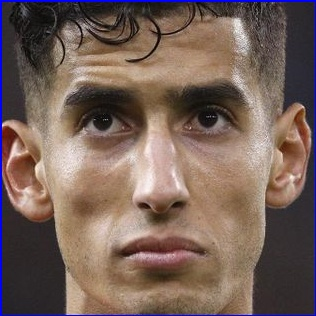

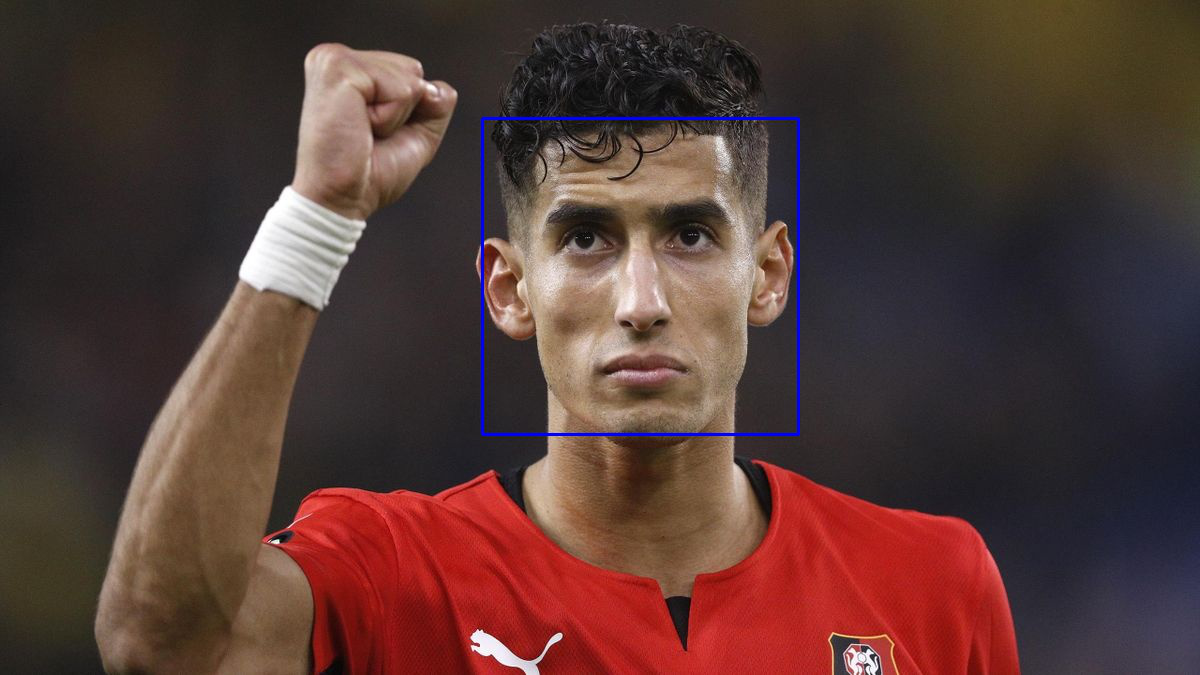

In [8]:
import cv2
from IPython.display import display, Image
import PIL.Image
import io

# Load the pre-trained face detector (Haar cascade)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Read the image (Ensure the image path us correct)
img = cv2.imread('aguerd.jpg')

# Convert the image to grayscale for face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=2)

# Loop through all the detected faces
for i, (x,y,w,h) in enumerate(faces):
    # Draw a rectangle around each detected face
    cv2.rectangle(img, (x,y), (x + w, y + h), (255, 0, 0), 2)
    face_roi = img[y:y + h, x:x + w]
    resized_face = cv2.resize(face_roi, (100, 100))

    # Save the cropped face to a file
    cv2.imwrite(f'detected_face_{i + 1}.jpg', cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY))

    # print the dimensions of the deteced face
    print(f"Detected Face {i + 1} Dimensions: Width={w}, Height={h}")
    display(Image(data=cv2.imencode('.jpg', face_roi)[1]))

# Convert the result to a format displayable in Jupyter
_, img_encoded = cv2.imencode('.jpg', img)
img_display = PIL.Image.open(io.BytesIO(img_encoded))

# Display the image with detected faces
display(img_display)

In [9]:
# Constants for LBP
RADIUS = 4
N_POINTS = 16
METHOD = 'uniform'

In [ ]:
# Example usage
# base_folder = "C:/Users/Dataset EquipeMaroc"  remplacer par le chemin de votre dataset
base_folder = ".Dataset EquipeMaroc"
images, labels, label_map = load_images_from_folder(base_folder)
print(label_map)
if images is not None:
    features = prepare_lbp_features(images, N_POINTS, RADIUS, 10, 10)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a classifier
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    print("Evaluating on test data...")
    X_test_scaled = scaler.transform(X_test)

    classifier = svm.SVC(kernel='linear', probability = True)
    classifier.fit(X_train_scaled, y_train)

    # Evaluate the model
    y_pred = classifier.predict(X_test_scaled)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Chargement des images depuis C:/Users/lenovo/OneDrive/Documents/Semestre 7/Opencv and Vision computer/Dataset EquipeMaroc\...
{0: 'aguerd', 1: 'Anass Zeroury', 2: 'boukhlal', 3: 'hakimi', 4: 'saiss', 5: 'Walid'}
Evaluating on test data...
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.80      0.89         5
           2       1.00      0.75      0.86         4
           3       0.86      1.00      0.92         6
           4       0.86      0.86      0.86         7
           5       0.83      1.00      0.91         5

    accuracy                           0.90        29
   macro avg       0.92      0.90      0.91        29
weighted avg       0.91      0.90      0.90        29



In [11]:
# Charger l'image du visage
image_path = "detected_face_1.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Vérification de l'image
if image is None:
    print("L'image n'a pas pu être chargée. Vérifiez le chemin.")
else:
    print("Image chargée avec succès.")
    image = cv2.resize(image, (200, 200))

# Extraire les caractéristiques LBP
lbp_features = extract_lbp_features_images(image, N_POINTS, RADIUS, 10, 10)

# Vérification des caractéristiques
if lbp_features is None or len(lbp_features) == 0:
    print("Erreur lors de l'extraction des caractéristiques.")
else:
    print(f"Caractéristiques LBP extraites : {lbp_features.shape[0]} dimensions.")

# Standardiser les caractéristiques
lbp_features = lbp_features.reshape(1, -1)
lbp_features_scaled = scaler.transform(lbp_features)

# Faire une prédiction
prediction = classifier.predict(lbp_features_scaled)
probabilities = classifier.predict_proba(lbp_features_scaled) if hasattr(classifier, 'predict_proba') else None

# Afficher le résultat
print(f"Classe prédite : {prediction[0]}")
if probabilities is not None:
    print(f"Probabilités : {probabilities}")
# Associer l'index à un label
if label_map:
    predicted_label = label_map[prediction[0]]
    print(f"Le visage appartient à la classe : {predicted_label}")
else:
    print("Mapping des labels non disponible.")


Image chargée avec succès.
Caractéristiques LBP extraites : 1800 dimensions.
Classe prédite : 0
Probabilités : [[0.35821636 0.1024428  0.09096753 0.17881503 0.19020264 0.07935564]]
Le visage appartient à la classe : aguerd
